# Pill Recognition Classify

### In this notebook, pill recognition algorithm will be established, model trained and saved for deployment to the object detection algorithm. CNN will be used at first, but due to the small dataset used for this purpose, Random Forest Classify will also be used and the best performing model adopted. 


In [1]:
# importation of the necessary librabries.

import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
from matplotlib.image import imread 
import seaborn as sns
import glob
import cv2

from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, BatchNormalization
from tensorflow.keras.optimizers import SGD

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.ensemble import RandomForestClassifier

from shutil import copyfile
from random import seed, random

import sys
import os
from os import walk

/Users/elias/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/elias/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/elias/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/elias/opt/anaconda3/lib/python3.7/site-packages/tensorflow/pyth

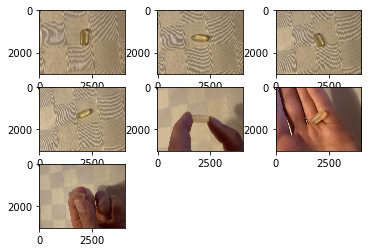

In [2]:
# EDA - a sneakpeak into the files in the medication (train dataset) folder. 

# load dataset

folder = "medication\\"

# plot first few images

for i in range(1, 8):
    # define subplot
    plt.subplot(330 + 0 + i)
    # define filename
    filename = folder + 'GeloMytrol' + str(i) + '.jpg'
    # load imgae pixels
    image = imread(filename)
    # plot raw pixel data
    plt.imshow(image)
# show the figure
plt.show()


In [3]:
# list the names of the files in the directory
filenames = os.listdir("medication\\")

In [4]:
len(filenames)

132

In [5]:
def pill_encoding(folder="medication\\"):
    """Convert the photos and labels from images and texts to numbers - encoding, 16 selected medications are encoded here"""
    """folder: specify the folder where the medication photos can be found"""

    # location of train set
    #folder = "medication\\"
    photos, labels = list(), list()

    # enumerate files in the directory
    for file in os.listdir(folder):
        # determine class
        output = 0.0
        if file.startswith("Bis"):
            output = 1.0
        if file.startswith("Candecor"):
            output = 2.0
        if file.startswith("Candes"):
            output = 3.0
        if file.startswith("Eunova"):
            output = 4.0
        if file.startswith("Gelo"):
            output = 5.0
        if file.startswith("Ibu"):
            output = 6.0
        if file.startswith("Imo"):
            output = 7.0
        if file.startswith("Klo"):
            output = 8.0
        if file.startswith("Lem"):
            output = 9.0
        if file.startswith("Lor"):
            output = 10.0
        if file.startswith("Nov"):
            output = 11.0
        if file.startswith("Sed"):
            output = 12.0
        if file.startswith("Tax"):
            output = 13.0
        if file.startswith("Tho"):
            output = 14.0
        if file.startswith("Vit"):
            output = 15.0
        
        # load image
        photo = load_img(folder + file, target_size=(300, 300))

        # convert to numpy array
        photo = img_to_array(photo)

        # store
        photos.append(photo)
        labels.append(output)

    # convert to numpy arrays
    photos = np.asarray(photos)
    labels = np.asarray(labels)

    return photos, labels

def save_encodings(filename1, filename2, data1, data2):
    """filename1: desired name of dataset 1, filename2: desired name of dataset 2"""
    # save the reshaped photos
    np.save(filename1, data1)
    np.save(filename2, data2)

In [6]:
photos, labels = pill_encoding("medication\\")
print(photos.shape, labels.shape)

save_encodings(filename1="trainset_photos.npy", filename2="trainset_labels.npy", data1=photos, data2=labels)

(132, 300, 300, 3) (132,)


In [7]:
# encode the test set
test_photos, test_labels = pill_encoding(folder="medication_testset\\")
print(test_photos.shape, test_labels.shape)

save_encodings(filename1="testset_photos.npy", filename2="testset_labels.npy", data1=test_photos, data2=test_labels)

(18, 300, 300, 3) (18,)


# Baseline CNN Model

The baseline model using CNN is expected to produce crappy result, given the size of the training set, random forest classify will be used in the hope of getting a better prediction. 

In [58]:
train_images = np.load("trainset_photos.npy")
train_labels = np.load("trainset_labels.npy")
test_images = np.load("testset_photos.npy")
test_labels = np.load("testset_labels.npy")

# Normalize the dataset
train_images, test_images = train_images/255.0, test_images/255.0

print(train_images.shape, train_labels.shape, test_images.shape, test_labels.shape)

(132, 300, 300, 3) (132,) (18, 300, 300, 3) (18,)


In [59]:
# reshape the labels

train_labels = train_labels.reshape(-1,1)
test_labels = test_labels.reshape(-1,1)

print(train_images.shape, train_labels.shape, test_images.shape, test_labels.shape)

(132, 300, 300, 3) (132, 1) (18, 300, 300, 3) (18, 1)


In [10]:
# define the model
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(300, 300, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(1, activation='sigmoid'))
# compile model
opt = SGD(lr=0.001, momentum=0.9)
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])



# train the model
history = model.fit(train_images, train_labels, epochs=20, verbose=2, validation_data= (test_images, test_labels))


C:\Users\chiso\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(
Epoch 1/20
5/5 - 7s - loss: -1.1482e+10 - accuracy: 0.0455 - val_loss: -9.0619e+20 - val_accuracy: 0.0556
Epoch 2/20
5/5 - 6s - loss: nan - accuracy: 0.0530 - val_loss: nan - val_accuracy: 0.0556
Epoch 3/20
5/5 - 6s - loss: nan - accuracy: 0.0682 - val_loss: nan - val_accuracy: 0.0556
Epoch 4/20
5/5 - 6s - loss: nan - accuracy: 0.0682 - val_loss: nan - val_accuracy: 0.0556
Epoch 5/20
5/5 - 6s - loss: nan - accuracy: 0.0682 - val_loss: nan - val_accuracy: 0.0556
Epoch 6/20
5/5 - 6s - loss: nan - accuracy: 0.0682 - val_loss: nan - val_accuracy: 0.0556
Epoch 7/20
5/5 - 6s - loss: nan - accuracy: 0.0682 - val_loss: nan - val_accuracy: 0.0556
Epoch 8/20
5/5 - 6s - loss: nan - accuracy: 0.0682 - val_loss: nan 

1/1 - 0s - loss: nan - accuracy: 0.0556


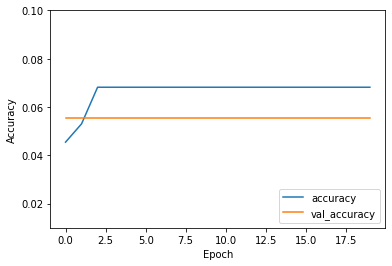

In [11]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.01, 0.1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)

In [12]:
print(test_acc)

0.0555555559694767


In [13]:
test_images.shape

(18, 300, 300, 3)

In [14]:
# modify the features and retrain the model
cnn_features = Sequential()
cnn_features.add(Conv2D(32, (3, 3), activation = 'sigmoid', padding = 'same', input_shape=(300,300,3)))
cnn_features.add(BatchNormalization())

cnn_features.add(Conv2D(32, (3, 3), activation = 'sigmoid', padding = 'same', kernel_initializer = 'he_uniform'))
cnn_features.add(BatchNormalization())
cnn_features.add(MaxPooling2D(2, 2))

cnn_features.add(Conv2D(64, (3, 3), activation = 'sigmoid', padding = 'same', kernel_initializer = 'he_uniform'))
cnn_features.add(BatchNormalization())

cnn_features.add(Conv2D(64, (3, 3), activation = 'sigmoid', padding = 'same', kernel_initializer = 'he_uniform'))
cnn_features.add(BatchNormalization())
cnn_features.add(MaxPooling2D(2, 2))

cnn_features.add(Flatten())

# Add layers for deep learning prediction
x = cnn_features.output  
x = Dense(128, activation = 'sigmoid', kernel_initializer = 'he_uniform')(x)
prediction_layer = Dense(1, activation = 'softmax')(x)

# Make a new model combining both feature extractor and x
cnn_model = Model(inputs=cnn_features.input, outputs=prediction_layer)
cnn_model.compile(optimizer='rmsprop',loss = 'binary_crossentropy', metrics = ['accuracy'])
print(cnn_model.summary())

#Train the CNN model
history = cnn_model.fit(train_images, train_labels, epochs=10, validation_data = (test_images, test_labels))

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1_input (InputLayer)  [(None, 300, 300, 3)]     0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 300, 300, 32)      896       
_________________________________________________________________
batch_normalization (BatchNo (None, 300, 300, 32)      128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 300, 300, 32)      9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 300, 300, 32)      128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 150, 150, 32)      0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 150, 150, 64)      18496 

# Baseline Model Using Convolutional Filters + Random Forest for image classification

### We will use features from CNN to train RandomForest

In [78]:
X_train, y_train, X_test, y_test = train_images, train_labels, test_images, test_labels

In [79]:
y_train = y_train.ravel()
y_test = y_test.ravel()

In [45]:
# initialize the features from CNN for RF
X_train = cnn_features.predict(X_train)
X_test = cnn_features.predict(X_test)

In [46]:
# Random Forest Model
rf_model = RandomForestClassifier(random_state = 42)

# Train the model on training data
rf_model.fit(X_train, y_train)

# Predict the test set
y_pred= rf_model.predict(X_test)

# Print overall accuracy
print("Accuracy = ", accuracy_score(y_test, y_pred))

Accuracy =  0.5


So far, the random forest model performed better than the convolutional neural network. Next, some hyper-parameter tuning will be implemented in order to see if the accuracy of the prediction could be improved. 

In [47]:
#Initialising hyperparameter grid
max_depth = [int(x) for x in np.linspace(start=10, stop=110, num= 11)]
max_depth.append(None)

param_dist = {
    'bootstrap': [True, False],
    'max_depth': max_depth,
    'max_features': ['auto', 'sqrt'],
    'min_samples_leaf': [int(x) for x in np.linspace(start=1, stop=50, num= 11)],
    'min_samples_split': [int(x) for x in np.linspace(start=1, stop=20, num= 11)],
    'n_estimators': [int(x) for x in np.linspace(start=200, stop=2000, num= 10)]
}

# Randomized Search CV
rand_search = RandomizedSearchCV(estimator = rf_model, param_distributions= param_dist, n_iter= 100, cv= 3, verbose= 2, random_state= 42, n_jobs= -1)

# Train the model on training data
rand_search.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
C:\Users\chiso\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\sklearn\model_selection\_search.py:922: UserWarning: One or more of the test scores are non-finite: [0.17424242 0.52272727 0.14393939 0.25              nan 0.14393939
 0.31818182 0.37121212 0.46212121 0.14393939 0.1969697  0.46212121
        nan 0.26515152 0.40151515 0.14393939 0.27272727 0.14393939
        nan 0.5530303  0.26515152 0.46969697 0.34848485 0.21969697
 0.34848485 0.32575758 0.14393939 0.31818182 0.14393939 0.47727273
 0.39393939 0.14393939 0.54545455 0.40909091 0.38636364 0.49242424
 0.14393939 0.17424242 0.26515152 0.14393939 0.61363636 0.5530303
 0.49242424 0.14393939 0.25757576 0.14393939 0.42424242 0.34848485
 0.34848485 0.14393939 0.14393939 0.14393939 0.40151515 0.1969697
 0.17424242 0.14393939 0.26515152 0.52272727 0.14393939 0.48484848
 0.34848485 0.1969697  0.5151515

RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(random_state=42),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 5, 10, 15, 20,
                                                             25, 30, 35, 40, 45,
                                                             50],
                                        'min_samples_split': [1, 2, 4, 6, 8, 10,
                                                              12, 14, 16, 18,
                                                              20],
                                        'n_estimators': [200, 400, 600, 8

In [48]:
#print best paramaters from Random Search
rand_search.best_params_

{'n_estimators': 1400,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': None,
 'bootstrap': False}

In [49]:
#get best performing model from Random Search
best = rand_search.best_estimator_
best.fit(X_train, y_train)
y_pred = best.predict(X_test)

In [50]:
# Print overall accuracy
print("Accuracy = ", accuracy_score(y_pred, y_test))

Accuracy =  0.5555555555555556


Reshape the numpy array from 4D to 2D and train the model again without CNN features, as well as use randomized search CV to get the best params. If need be, use GridSearch to Narrow the parameters down even more. 

In [80]:
X_train.shape

(132, 300, 300, 3)

In [81]:
X_train = X_train.swapaxes(1,2).reshape(39600, 132)
X_test = X_test.swapaxes(1,2).reshape(5400, 132)

ValueError: cannot reshape array of size 35640000 into shape (39600,132)

In [77]:
# Random Forest Model 2
rf_model = RandomForestClassifier(random_state = 42)

# Train the model on training data
rf_model.fit(X_train, y_train)

# Predict the test set
y_pred= rf_model.predict(X_test)

# Print overall accuracy
print("Accuracy = ", accuracy_score(y_test, y_pred))

ValueError: Found input variables with inconsistent numbers of samples: [39600, 132]

In [ ]:
#Initialising hyperparameter grid
max_depth = [int(x) for x in np.linspace(start=10, stop=110, num= 11)]
max_depth.append(None)

param_dist = {
    'bootstrap': [True, False],
    'max_depth': max_depth,
    'max_features': ['auto', 'sqrt'],
    'min_samples_leaf': [int(x) for x in np.linspace(start=1, stop=50, num= 11)],
    'min_samples_split': [int(x) for x in np.linspace(start=1, stop=20, num= 11)],
    'n_estimators': [int(x) for x in np.linspace(start=200, stop=2000, num= 10)]
}

# Randomized Search CV
rand_search = RandomizedSearchCV(estimator = rf_model, param_distributions= param_dist, n_iter= 100, cv= 3, verbose= 2, random_state= 42, n_jobs= -1)

# Train the model on training data
rand_search.fit(X_train, y_train)

In [ ]:
#print best paramaters from Random Search
rand_search.best_params_

In [ ]:
#get best performing model from Random Search
best = rand_search.best_estimator_
best.fit(X_train, y_train)
y_pred = best.predict(X_test)

In [ ]:
# Print overall accuracy
print("Accuracy = ", accuracy_score(y_pred, y_test))